# Time Series Analysis

We see that the dataset has four columns.As i am usually ARIMA it is not usually used for multivariate analysis. So we will break the dataset into two different tables.
## Tables are:
1. Flow in
2. Flow out

Now we will be able to do time series analysis by doing univariate analysis as we have only one variable that is count for a particular time period.


In [8]:
from pandas import datetime
import pandas as pd
from matplotlib import pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from statsmodels.tsa.stattools import adfuller
import numpy as np
from pandas import Series
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


# Reading and Parsing data
Here we are also splitting the data into two seperate tables 

In [80]:
values= pd.read_csv('call.csv', header=None, squeeze=True)
date = pd.to_datetime(values[1]+' '+values[2])
values.drop([1,2],axis=1,inplace=True)
values['date']=date

#seperating flowin and flowout 
flowin=values.loc[values[0]==7]
flowout=values.loc[values[0]==9]

flowin.set_index(flowin['date'],inplace=True)
flowout.set_index(flowout['date'],inplace=True)


flowin.drop([0,'date'],axis=1,inplace=True)
flowout.drop([0,'date'],axis=1,inplace=True)
print (flowin.info())
print (flowout.info())
print (flowin.head())
print(flowout.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5040 entries, 2005-07-24 00:00:00 to 2005-11-05 23:30:00
Data columns (total 1 columns):
3    5040 non-null int64
dtypes: int64(1)
memory usage: 78.8 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5040 entries, 2005-07-24 00:00:00 to 2005-11-05 23:30:00
Data columns (total 1 columns):
3    5040 non-null int64
dtypes: int64(1)
memory usage: 78.8 KB
None
                     3
date                  
2005-07-24 00:00:00  0
2005-07-24 00:30:00  1
2005-07-24 01:00:00  0
2005-07-24 01:30:00  0
2005-07-24 02:00:00  0
                     3
date                  
2005-07-24 00:00:00  0
2005-07-24 00:30:00  0
2005-07-24 01:00:00  0
2005-07-24 01:30:00  0
2005-07-24 02:00:00  0


# Starting with flowin table
## Data visualization
We are visualizing the original values in blue and the predited values in red

### Important:
Time series can give better predictions when it is stationary and is not having any trends,seasonal patterns.If the time series is not stationary then we have to convert the non-stationary time series to stationary time series.


 



In [11]:
X = np.array(flowin[3])
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -11.583737
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567



### ADFuller Test
You can use this statistical test to check if the expectations of stationarity are met or have been violated.It uses hypothesis testing.

Here the ADF Statistic: -11.583737
Hence this test rejects null hypothesis . Therefore the time series is not non-stationary

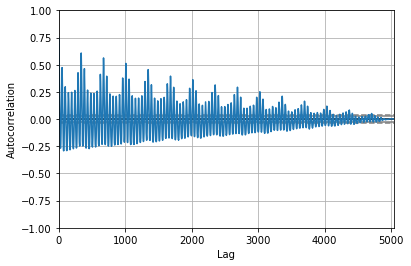

In [12]:
autocorrelation_plot(flowin)


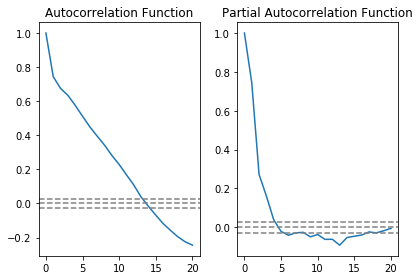

In [16]:
lag_acf = acf(flowin, nlags=20)
lag_pacf = pacf(flowin, nlags=20)

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(flowin)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(flowin)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(flowin)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(flowin)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


# Arima models works on the basis of three parameters
AR (Autoregression) -->p<br>
I  (Integrated)     -->d<br>
MA (Moving Average) -->q<br>

We can find (p,q,d) by the help of ACF and PACF plots. Plotting it 

We see p=4<br>
We see q=13 (Very high value)





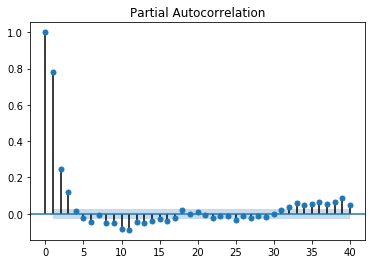

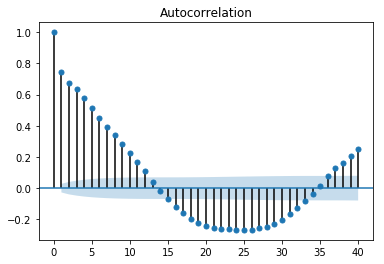

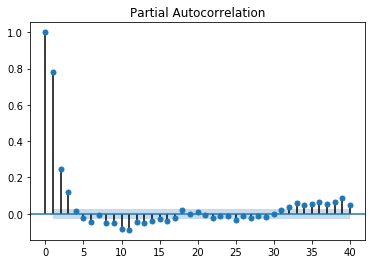

In [25]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(flowin,lags=40)
plot_pacf(flowout,lags=40)


ACF plot is like a geometric curve which is decaying and PACF plot is also like a geometric curve which is also decaying .<br>
Hence we are using <br>
p=4 (as there are 4 significant lags)<br>
q=2 or 1 (on the basis of PACF curve as ACF curve lags are many )

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5040
Model:                     ARMA(4, 2)   Log Likelihood              -13822.604
Method:                       css-mle   S.D. of innovations              3.756
Date:                Sat, 21 Apr 2018   AIC                          27661.208
Time:                        14:47:58   BIC                          27713.409
Sample:                             0   HQIC                         27679.496
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7389      0.178     21.056      0.000       3.391       4.087
ar.L1.y        2.3782      0.018    130.985      0.000       2.343       2.414
ar.L2.y       -1.6234      0.040    -40.908      0.0

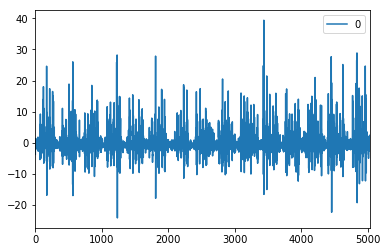

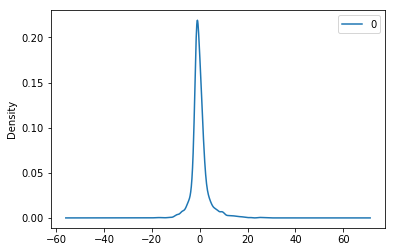

                 0
count  5040.000000
mean     -0.000077
std       3.756972
min     -24.182401
25%      -1.485688
50%      -0.569152
75%       0.889170
max      39.407102


In [28]:

flowin1=np.asarray(flowin.astype(float))
model = ARIMA(flowin1, order=(4,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())


## Finally training flowin data
After training the flowin data we are visualizing the actual values by blue and the predicted values by red. 

predicted=0.953025, expected=0.000000
predicted=0.946097, expected=0.000000
predicted=0.944150, expected=0.000000
predicted=0.945677, expected=1.000000
predicted=1.394888, expected=0.000000
predicted=1.103444, expected=0.000000
predicted=1.085394, expected=1.000000
predicted=1.495271, expected=6.000000
predicted=3.844167, expected=5.000000
predicted=4.248420, expected=1.000000
predicted=3.013900, expected=0.000000
predicted=2.312541, expected=5.000000
predicted=4.091459, expected=4.000000
predicted=4.018780, expected=2.000000
predicted=3.334314, expected=4.000000
predicted=4.029026, expected=9.000000
predicted=6.342116, expected=4.000000
predicted=4.938061, expected=0.000000
predicted=3.088357, expected=3.000000
predicted=3.634255, expected=12.000000
predicted=7.397927, expected=1.000000
predicted=3.704153, expected=2.000000
predicted=3.606462, expected=1.000000
predicted=2.608367, expected=0.000000
predicted=1.638784, expected=0.000000
predicted=1.096899, expected=0.000000
predicted=0

predicted=8.889419, expected=8.000000
predicted=7.762746, expected=9.000000
predicted=7.573322, expected=4.000000
predicted=4.907339, expected=5.000000
predicted=4.461608, expected=1.000000
predicted=2.034624, expected=3.000000
predicted=2.057800, expected=3.000000
predicted=1.677141, expected=0.000000
predicted=0.123354, expected=3.000000
predicted=1.061714, expected=1.000000
predicted=0.256891, expected=1.000000
predicted=0.202441, expected=0.000000
predicted=-0.256235, expected=1.000000
predicted=0.144477, expected=1.000000
predicted=0.287740, expected=0.000000
predicted=0.006914, expected=0.000000
predicted=0.054349, expected=0.000000
predicted=0.117685, expected=0.000000
predicted=0.204290, expected=0.000000
predicted=0.302889, expected=1.000000
predicted=0.867447, expected=1.000000
predicted=1.105017, expected=0.000000
predicted=0.851775, expected=0.000000
predicted=0.878158, expected=0.000000
predicted=0.887919, expected=0.000000
predicted=0.900974, expected=2.000000
predicted=1

predicted=1.286294, expected=0.000000
predicted=1.010925, expected=2.000000
predicted=1.908182, expected=0.000000
predicted=1.288889, expected=2.000000
predicted=2.119536, expected=2.000000
predicted=2.337458, expected=0.000000
predicted=1.608227, expected=0.000000
predicted=1.423683, expected=0.000000
predicted=1.255187, expected=2.000000
predicted=2.030382, expected=9.000000
predicted=5.398636, expected=11.000000
predicted=7.522665, expected=8.000000
predicted=7.401958, expected=6.000000
predicted=6.920095, expected=22.000000
predicted=14.087391, expected=4.000000
predicted=8.197823, expected=7.000000
predicted=8.548132, expected=14.000000
predicted=11.119707, expected=8.000000
predicted=9.000483, expected=8.000000
predicted=8.548455, expected=6.000000
predicted=7.169407, expected=12.000000
predicted=9.171257, expected=17.000000
predicted=11.766877, expected=23.000000
predicted=15.550969, expected=19.000000
predicted=15.430110, expected=14.000000
predicted=13.775994, expected=16.0000

predicted=10.710022, expected=9.000000
predicted=9.491160, expected=6.000000
predicted=7.020537, expected=16.000000
predicted=10.293119, expected=11.000000
predicted=8.588421, expected=9.000000
predicted=7.539549, expected=6.000000
predicted=5.735612, expected=3.000000
predicted=3.615121, expected=2.000000
predicted=2.170021, expected=0.000000
predicted=0.422401, expected=2.000000
predicted=0.493821, expected=1.000000
predicted=-0.191020, expected=0.000000
predicted=-0.818604, expected=0.000000
predicted=-0.997242, expected=1.000000
predicted=-0.581138, expected=4.000000
predicted=1.001894, expected=0.000000
predicted=-0.095715, expected=0.000000
predicted=-0.052054, expected=0.000000
predicted=-0.023393, expected=0.000000
predicted=0.048085, expected=0.000000
predicted=0.145507, expected=0.000000
predicted=0.256015, expected=0.000000
predicted=0.370165, expected=0.000000
predicted=0.481314, expected=0.000000
predicted=0.584990, expected=0.000000
predicted=0.678531, expected=0.000000
p

predicted=0.143861, expected=0.000000
predicted=0.293959, expected=0.000000
predicted=0.432048, expected=0.000000
predicted=0.555181, expected=0.000000
predicted=0.662086, expected=0.000000
predicted=0.752645, expected=0.000000
predicted=0.827614, expected=0.000000
predicted=0.888259, expected=0.000000
predicted=0.936144, expected=0.000000
predicted=0.972970, expected=1.000000
predicted=1.448196, expected=2.000000
predicted=2.067178, expected=0.000000
predicted=1.459528, expected=6.000000
predicted=4.054743, expected=4.000000
predicted=3.963499, expected=6.000000
predicted=5.205175, expected=7.000000
predicted=6.141582, expected=16.000000
predicted=10.662262, expected=9.000000
predicted=9.210467, expected=19.000000
predicted=13.886553, expected=17.000000
predicted=14.478144, expected=6.000000
predicted=10.323025, expected=8.000000
predicted=9.933173, expected=18.000000
predicted=13.517882, expected=8.000000
predicted=9.845240, expected=15.000000
predicted=12.137055, expected=14.000000


predicted=1.026480, expected=1.000000
predicted=1.473871, expected=0.000000
predicted=1.176610, expected=3.000000
predicted=2.491525, expected=2.000000
predicted=2.451059, expected=1.000000
predicted=2.196610, expected=2.000000
predicted=2.598430, expected=2.000000
predicted=2.678938, expected=3.000000
predicted=3.185565, expected=6.000000
predicted=4.699402, expected=1.000000
predicted=3.040072, expected=1.000000
predicted=2.739195, expected=0.000000
predicted=1.952186, expected=2.000000
predicted=2.432024, expected=1.000000
predicted=1.958466, expected=18.000000
predicted=9.411774, expected=0.000000
predicted=3.830759, expected=12.000000
predicted=8.430987, expected=0.000000
predicted=4.151672, expected=1.000000
predicted=3.556839, expected=0.000000
predicted=2.359207, expected=0.000000
predicted=1.640924, expected=1.000000
predicted=1.549319, expected=1.000000
predicted=1.331708, expected=0.000000
predicted=0.765981, expected=0.000000
predicted=0.551453, expected=1.000000
predicted=

predicted=-0.026164, expected=1.000000
predicted=0.340249, expected=0.000000
predicted=0.083682, expected=0.000000
predicted=0.096299, expected=0.000000
predicted=0.153768, expected=0.000000
predicted=0.237200, expected=0.000000
predicted=0.334355, expected=0.000000
predicted=0.436167, expected=0.000000
predicted=0.536186, expected=0.000000
predicted=0.630069, expected=0.000000
predicted=0.715135, expected=1.000000
predicted=1.224997, expected=0.000000
predicted=1.023171, expected=1.000000
predicted=1.461955, expected=2.000000
predicted=2.071776, expected=0.000000
predicted=1.494874, expected=1.000000
predicted=1.796145, expected=4.000000
predicted=3.166771, expected=12.000000
predicted=7.195244, expected=7.000000
predicted=6.745137, expected=33.000000
predicted=18.408071, expected=18.000000
predicted=16.578574, expected=7.000000
predicted=12.291361, expected=3.000000
predicted=8.915470, expected=18.000000
predicted=13.640383, expected=10.000000
predicted=11.180855, expected=12.000000


predicted=5.507236, expected=7.000000
predicted=6.413968, expected=10.000000
predicted=8.082770, expected=28.000000
predicted=16.711178, expected=22.000000
predicted=17.592650, expected=10.000000
predicted=13.454629, expected=17.000000
predicted=15.374092, expected=9.000000
predicted=12.148279, expected=5.000000
predicted=9.015132, expected=7.000000
predicted=8.234902, expected=11.000000
predicted=9.117034, expected=11.000000
predicted=9.076796, expected=20.000000
predicted=12.977471, expected=13.000000
predicted=11.319510, expected=22.000000
predicted=14.968604, expected=42.000000
predicted=25.418289, expected=29.000000
predicted=23.905950, expected=24.000000
predicted=22.103877, expected=37.000000
predicted=27.885281, expected=54.000000
predicted=37.708773, expected=40.000000
predicted=35.308242, expected=54.000000
predicted=42.342197, expected=18.000000
predicted=27.843666, expected=8.000000
predicted=17.906450, expected=3.000000
predicted=10.279126, expected=4.000000
predicted=6.42

predicted=0.881068, expected=0.000000
predicted=0.519554, expected=3.000000
predicted=1.955712, expected=0.000000
predicted=1.188573, expected=0.000000
predicted=0.682884, expected=1.000000
Test MSE: 18.764


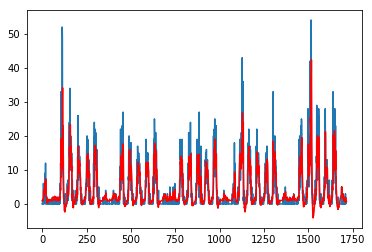

In [96]:
flowin=flowin.astype(float)
X = flowin.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:(len(X))] 
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(4,0,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

for i in range(3):
    model1 = ARIMA(history, order=(4,0,2))
    model1_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)
    
    
error = mean_squared_error(test, predictions[:1714])
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()


# Starting with flowout table

Same procedures as that of flowin table


In [32]:
X = np.array(flowout[3])
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -12.636841
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


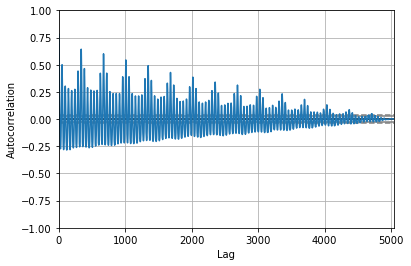

In [33]:
autocorrelation_plot(flowout)


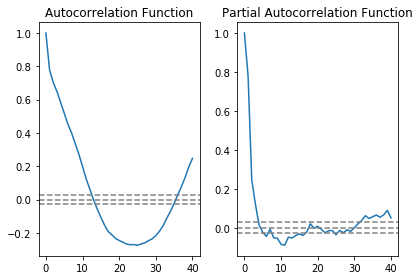

In [34]:
lag_acf = acf(flowout, nlags=40)
lag_pacf = pacf(flowout, nlags=40)

plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(flowout)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(flowout)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(flowout)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(flowout)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()


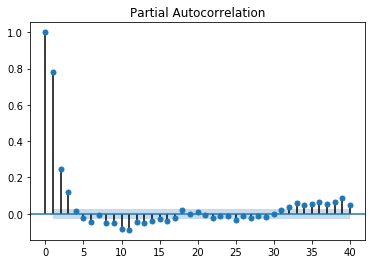

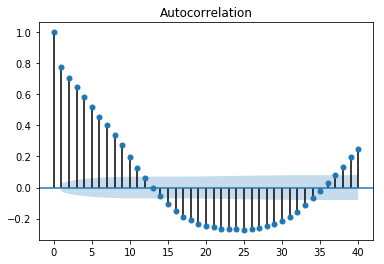

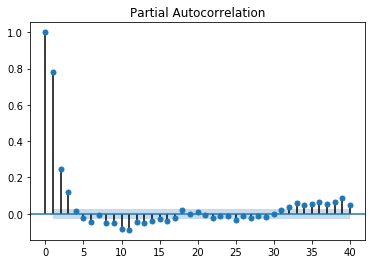

In [35]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(flowout,lags=40)
plot_pacf(flowout,lags=40)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5040
Model:                     ARMA(4, 2)   Log Likelihood              -14223.015
Method:                       css-mle   S.D. of innovations              4.067
Date:                Sat, 21 Apr 2018   AIC                          28462.029
Time:                        15:15:50   BIC                          28514.231
Sample:                             0   HQIC                         28480.318
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8913      0.213     18.281      0.000       3.474       4.309
ar.L1.y        2.1753      0.050     43.715      0.000       2.078       2.273
ar.L2.y       -1.3914      0.073    -19.024      0.0

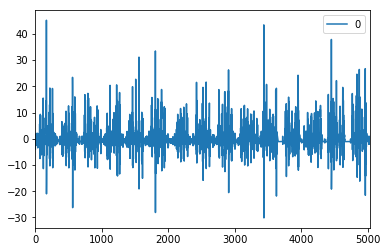

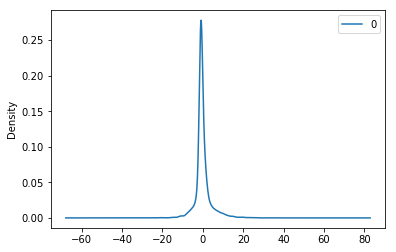

                 0
count  5040.000000
mean     -0.000397
std       4.067816
min     -30.164657
25%      -1.080488
50%      -0.799716
75%       0.620283
max      45.210245


In [36]:

flowout1=np.asarray(flowout1.astype(float))
model1 = ARIMA(flowout, order=(4,0,2))
model1_fit = model1.fit(disp=0)
print(model1_fit.summary())
# plot residual errors
residuals = DataFrame(model1_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())


predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=1.000000
predicted=0.563555, expected=0.000000
predicted=0.204538, expected=9.000000
predicted=5.250370, expected=5.000000
predicted=4.678555, expected=1.000000
predicted=3.209353, expected=1.000000
predicted=1.859399, expected=1.000000
predicted=1.111955, expected=4.000000
predicted=2.938307, expected=2.000000
predicted=2.282377, expected=4.000000
predicted=3.432490, expected=6.000000
predicted=4.665784, expected=4.000000
predicted=4.293311, expected=0.000000
predicted=2.089691, expected=2.000000
predicted=2.043300, expected=8.000000
predicted=5.148837, expected=1.000000
predicted=2.744143, expected=1.000000
predicted=2.350863, expected=0.000000
predicted=0.554861, expected=0.000000
predicted=0.318108, expected=0.000000
predicted=0.239352, expected=0.000000
predicted

predicted=9.207908, expected=7.000000
predicted=8.195337, expected=4.000000
predicted=5.500980, expected=0.000000
predicted=2.601257, expected=6.000000
predicted=4.721613, expected=9.000000
predicted=6.775649, expected=0.000000
predicted=2.830567, expected=1.000000
predicted=2.267822, expected=3.000000
predicted=2.321664, expected=0.000000
predicted=1.053248, expected=0.000000
predicted=0.659940, expected=1.000000
predicted=0.684627, expected=0.000000
predicted=0.279732, expected=0.000000
predicted=0.212782, expected=0.000000
predicted=0.022243, expected=0.000000
predicted=0.028045, expected=0.000000
predicted=0.015954, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted

predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=1.000000
predicted=0.591435, expected=0.000000
predicted=0.181517, expected=0.000000
predicted=0.153759, expected=0.000000
predicted=0.029875, expected=5.000000
predicted=2.985808, expected=2.000000
predicted=2.105576, expected=1.000000
predicted=1.723200, expected=1.000000
predicted=1.230532, expected=8.000000
predicted=5.268947, expected=9.000000
predicted=7.089474, expected=18.000000
predicted=13.608598, expected=11.000000
predicted=11.445272, expected=10.000000
predicted=11.180855, expected=9.000000
predicted=9.747674, expected=12.000000
predicted=11.249291, expected=6.000000
predicted=8.005963, expected=20.000000
predicted=15.469397, expected=17.000000
predicted=15.397083, expected=22.000000
predicted=19.800634, expected=11.000000
predicted=14.109390, expected=24.000000
predicted=20.628057, expected=13.000000
predicted=15.320888, expected=15.000000
predicted=16.019369, expected=27.000000
predicted=22.089987, expe

predicted=20.742128, expected=16.000000
predicted=18.234763, expected=15.000000
predicted=16.364949, expected=10.000000
predicted=12.731825, expected=10.000000
predicted=11.429979, expected=11.000000
predicted=11.098621, expected=6.000000
predicted=8.056575, expected=2.000000
predicted=4.766332, expected=0.000000
predicted=2.058954, expected=0.000000
predicted=0.931312, expected=0.000000
predicted=0.393897, expected=0.000000
predicted=0.144404, expected=0.000000
predicted=0.033341, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.00

predicted=0.014769, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=5.000000
predicted=2.951733, expected=3.000000
predicted=2.722843, expected=6.000000
predicted=4.846702, expected=12.000000
predicted=8.868305, expected=12.000000
predicted=10.466820, expected=16.000000
predicted=13.870866, expected=10.000000
predicted=11.346630, expected=14.000000
predicted=13.306773, expected=15.000000
predicted=14.023994, expected=17.000000
predicted=15.820329, expected=11.000000
predicted=12.908329, expected=22.000000
predicted=18.572965, expect

predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=1.000000
predicted=0.594999, expected=0.000000
predicted=0.194230, expected=0.000000
predicted=0.140769, expected=0.000000
predicted=0.040214, expected=0.000000
predicted=0.014063, expected=0.000000
predicted=0.016131, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=2.000000
predicted=1.189984, expected=19.000000
predicted=11.702196, expected=0.000000
predicted=3.994208, expected=5.000000
predicted=5.728745, expected=0.000000
predicted=1.793268, expected=0.000000
predicted=1.009289, expected=0.000000
predicted=0.520892, expected=0.000000
predicted=0.071916, expected=0.000000
pred

predicted=0.013249, expected=0.000000
predicted=0.012587, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=1.000000
predicted=0.585712, expected=0.000000
predicted=0.205177, expected=1.000000
predicted=0.722986, expected=3.000000
predicted=2.008672, expected=0.000000
predicted=0.766142, expected=4.000000
predicted=2.813211, expected=8.000000
predicted=5.658440, expected=18.000000
predicted=12.798186, expected=32.000000
predicted=23.854802, expected=23.000000
predicted=22.967988, expected=21.000000
predicted=22.398149, expected=9.00000

predicted=1.303348, expected=11.000000
predicted=7.100671, expected=18.000000
predicted=13.123686, expected=14.000000
predicted=13.494654, expected=11.000000
predicted=12.253292, expected=19.000000
predicted=16.427143, expected=14.000000
predicted=14.738293, expected=20.000000
predicted=18.040699, expected=10.000000
predicted=13.069266, expected=11.000000
predicted=12.324286, expected=12.000000
predicted=11.993403, expected=13.000000
predicted=12.574222, expected=19.000000
predicted=16.225801, expected=16.000000
predicted=15.899882, expected=10.000000
predicted=12.611055, expected=27.000000
predicted=21.274594, expected=18.000000
predicted=18.748749, expected=11.000000
predicted=14.658152, expected=11.000000
predicted=12.690728, expected=23.000000
predicted=18.789968, expected=28.000000
predicted=23.616012, expected=22.000000
predicted=22.496969, expected=41.000000
predicted=33.706842, expected=53.000000
predicted=44.511564, expected=34.000000
predicted=38.066781, expected=46.000000
pr

predicted=0.094873, expected=0.000000
predicted=0.041024, expected=0.000000
predicted=0.003535, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=0.000000, expected=0.000000
predicted=-0.000000, expected=0.000000
Test MSE: 21.312


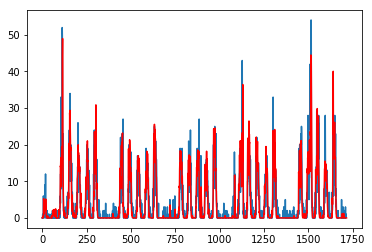

In [97]:
flowout=flowout.astype(float)
X = flowout.values
size = int(len(X) * 0.66)
train1, test1 = X[0:size], X[size:(len(X))] 
history = [x for x in train1]
predictions_out = list()
for t in range(len(test1)):
    model1 = ARIMA(history, order=(5,1,0))
    model1_fit = model1.fit(disp=0)
    output = model1_fit.forecast()
    yhat = output[0]
    predictions_out.append(yhat)
    obs = test1[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test1, predictions_out[:1714])
print('Test MSE: %.3f' % error)


for i in range(3):
    model1 = ARIMA(history, order=(5,1,0))
    model1_fit = model1.fit(disp=0)
    output = model1_fit.forecast()
    yhat = output[0]
    predictions_out.append(yhat)
    history.append(yhat)
    
    
    
# plot
plt.plot(test)
plt.plot(predictions_out, color='red')
plt.show()

# Calculating people inside the building 
Visualizing people count inside of the building

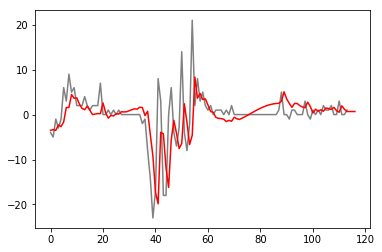

In [98]:
# since it's a list of arrays
in_arr = np.vstack(predictions)
out_arr = np.vstack(predictions_out)
test_count = test[1600: ] - test1[1600: ]

prediction_count = in_arr[1600:] - out_arr[1600:]
plt.plot(test_count, color='gray')
plt.plot(prediction_count, color='red')
plt.show()


In [99]:
# next three predictions are

print (prediction_count[-3])
print (prediction_count[-2])
print (prediction_count[-1])

[ 0.68288339]
[ 0.68288329]
[ 0.6828834]
